In [154]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from scipy import signal, fftpack
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras import utils
utils.to_categorical

<function keras.utils.np_utils.to_categorical(y, num_classes=None, dtype='float32')>

In [155]:
# Fungsi untuk menghitung highest peak PSD dari data
def calculate_highest_peak_psd(psd):
    return max(psd)

# List untuk menyimpan nilai highest peak PSD dan kelas data
highest_peak_psd_list = []
class_labels = []

# Daftar folder yang berisi data untuk masing-masing kelas
folder_paths = ['E:/LSTM/4_class/class1/', 
                'E:/LSTM/4_class/class2/', 
                'E:/LSTM/4_class/class3/', 
                'E:/LSTM/4_class/class4/']

In [172]:
# Loop untuk membaca dan memproses data dari folder
for class_idx, folder_path in enumerate(folder_paths):
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        # df = pd.read_csv(file_path)
        df_uncut = pd.read_csv(file_path)
        start_index = 1
        end_index = 1551
        df = df_uncut[start_index:end_index]
        data = df['Y'].values
        
        # Lakukan proses filtering, FFT, dan perhitungan PSD seperti pada kode sebelumnya
        # ...
        # ...
        # lowcut = 0.5
        # highcut = 2.0
        # fs =  400
        # order = 10
        lowcut = 2.0
        highcut = 10.0
        fs = 5000000.0
        order = 2

        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
    
        #Filter bandpass
        filtered_signal = signal.filtfilt(b, a, data)
    
        # Rectify signal
        rectified_signal = np.abs(filtered_signal)
    
        # One-sided FFT
        signal_fft = np.fft.fft(filtered_signal)
        signal_freq = np.fft.fftfreq(len(filtered_signal), 1/fs)
        n = len(filtered_signal)
        freq = signal_freq[0:int(n/2)]
        fft_amp = np.abs(signal_fft)[0:int(n/2)]/n*2
    
        # One-sided PSD
        psd = (1/(fs*n)) * np.square(np.abs(signal_fft[:n//2]))
        freq_psd = signal_freq[0:int(n/2)]
        psd_one_side = psd[0:int(n/2)]
    
        # Hitung highest peak PSD dan tambahkan ke dalam list
        highest_peak_psd = calculate_highest_peak_psd(psd_one_side)
        highest_peak_psd_list.append(highest_peak_psd)
    
        # Tambahkan kelas (label) ke dalam list
        class_label = f'class{class_idx + 1}'
        class_labels.append(class_label)

In [173]:
# Ubah label kelas menjadi angka dengan LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(class_labels)
y_encoded = utils.to_categorical(y)
num_classes = len(label_encoder.classes_)
print(y_encoded.shape)

(200, 4)


In [174]:
# Ubah fitur menjadi bentuk 3D [jumlah_sampel, jumlah_waktu, jumlah_fitur]
X = np.array(highest_peak_psd_list).reshape(-1, 1, 1)

# Pisahkan data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [178]:
# Konstruksi model LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training model
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split=0.5)

Epoch 1/1000
5/5 [==============================] - 6s 479ms/step - loss: 1.3863 - accuracy: 0.1750 - val_loss: 1.3864 - val_accuracy: 0.2375
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.3853 - accuracy: 0.2875 - val_loss: 1.3870 - val_accuracy: 0.2125
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.3844 - accuracy: 0.3125 - val_loss: 1.3876 - val_accuracy: 0.2125
Epoch 4/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.3831 - accuracy: 0.3125 - val_loss: 1.3882 - val_accuracy: 0.2125
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.3816 - accuracy: 0.3125 - val_loss: 1.3889 - val_accuracy: 0.2125
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.3805 - accuracy: 0.3125 - val_loss: 1.3897 - val_accuracy: 0.2125
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.3793 - accuracy: 0.3125 - val_loss: 1.3905 - val_accuracy: 0.2125
Epoch 8/1000

In [ ]:
# Evaluasi performa pada data latih
training_scores = model.evaluate(X_train, y_train)
print("Performa pada Data Latih:")
print("Loss:", training_scores[0])
print("Akurasi:", training_scores[1])

3/3 [==============================] - 1s 4ms/step - loss: 1.4024 - accuracy: 0.2375
Performa pada Data Latih:
Loss: 1.4023730754852295
Akurasi: 0.23749999701976776


In [ ]:
# Evaluasi model menggunakan data testing
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy*100)

1/1 [==============================] - 0s 40ms/step - loss: 1.3879 - accuracy: 0.3000
Test Loss: 1.3878822326660156
Test Accuracy: 30.000001192092896


# Kumpulan Plot

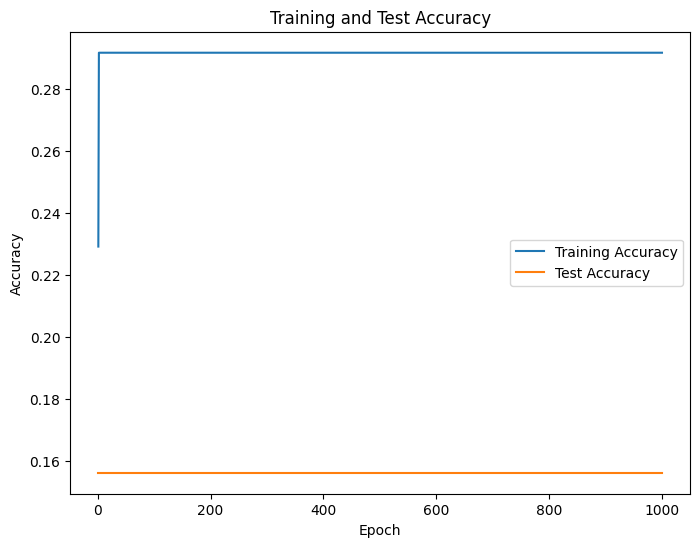

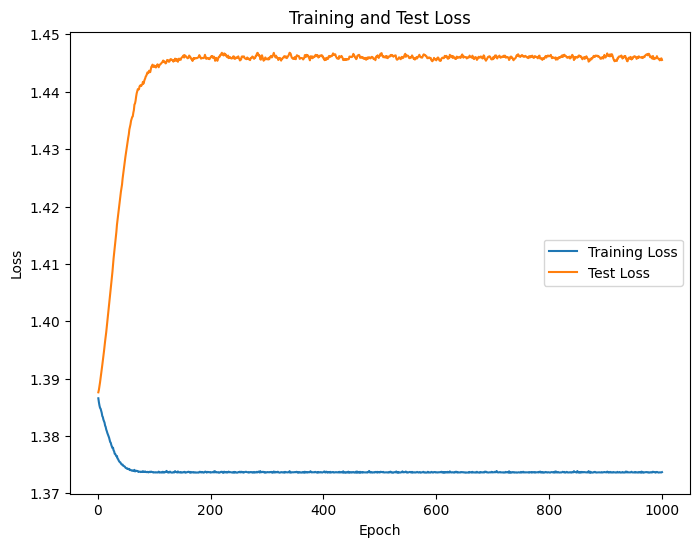

In [ ]:
# Batch Size 16 Split test 0.4 
# FS 400, order 10
# Ambil histori akurasi dan loss dari proses pelatihan
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Buat plot untuk akurasi
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Buat plot untuk loss 
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [ ]:
# # Batch Size 8 Split test 0.4
# # Ambil histori akurasi dan loss dari proses pelatihan
# train_accuracy = history.history['accuracy']
# test_accuracy = history.history['val_accuracy']
# train_loss = history.history['loss']
# test_loss = history.history['val_loss']

# # Buat plot untuk akurasi
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
# plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy')
# plt.legend()
# plt.show()

# # Buat plot untuk loss 
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
# plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Test Loss')
# plt.legend()
# plt.show()

In [ ]:
# # Batch Size 16 Split test 0.4
# # Ambil histori akurasi dan loss dari proses pelatihan
# train_accuracy = history.history['accuracy']
# test_accuracy = history.history['val_accuracy']
# train_loss = history.history['loss']
# test_loss = history.history['val_loss']

# # Buat plot untuk akurasi
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
# plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy')
# plt.legend()
# plt.show()

# # Buat plot untuk loss 
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
# plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Test Loss')
# plt.legend()
# plt.show()

# Prediksi

In [ ]:
# Prediksi pada data testing
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Ambil indeks kelas tertinggi sebagai prediksi

1/1 [==============================] - 1s 1s/step


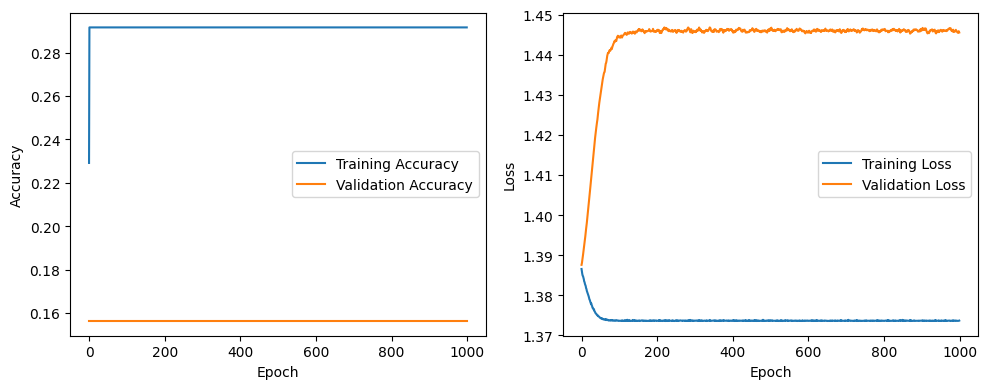

In [ ]:
# Plot akurasi dan loss selama pelatihan
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Ubah kembali one-hot encoded labels menjadi label kelas asli
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
# Buat laporan performa
target_names = [f'class{i+1}' for i in range(num_classes)]
report = classification_report(y_test_labels, y_pred_labels, target_names=target_names)

# Tampilkan laporan performa
print("Performance Report:")
print(report)

Performance Report:
              precision    recall  f1-score   support

      class1       0.00      0.00      0.00         6
      class2       0.30      1.00      0.46         6
      class3       0.00      0.00      0.00         3
      class4       0.00      0.00      0.00         5

    accuracy                           0.30        20
   macro avg       0.07      0.25      0.12        20
weighted avg       0.09      0.30      0.14        20



c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# Mapping label ke class_mapping
class_mapping = {
    'class1': 'Density 30%',
    'class2': 'Density 50%',
    'class3': 'Density 70%',
    'class4': 'Density 90%'
}

# Ubah kelas prediksi menjadi label sesuai class_mapping
predicted_class_labels = [class_mapping[f'class{idx+1}'] for idx in y_pred_labels]

# Tampilkan hasil prediksi
print("Predicted Class Labels:")
print(predicted_class_labels)

Predicted Class Labels:
['Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%', 'Density 50%']


In [ ]:
# Simpan model ke file .h5
model_filename = 'signal2.h5'
model.save(model_filename)

In [184]:
# Mapping label kelas
class_mapping = {
    'class1': 'Density 30%',
    'class2': 'Density 50%',
    'class3': 'Density 70%',
    'class4': 'Density 90%'
}

In [185]:
import tensorflow as tf
# Contoh prediksi pada file baru
# Ganti "new_data_file.csv" dengan file CSV yang ingin diprediksi
new_data_file = 'S703.csv'
df_new = pd.read_csv(new_data_file)
data_new = df_new['Y'].values

lowcut = 0.5
highcut = 2.5
fs = 400000.0
order = 2

nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(order, [low, high], btype='band')
    
#Filter bandpass
filtered_signal = signal.filtfilt(b, a, data)
    
# Rectify signal
rectified_signal = np.abs(filtered_signal)
    
# One-sided FFT
signal_fft = np.fft.fft(filtered_signal)
signal_freq = np.fft.fftfreq(len(filtered_signal), 1/fs)
n = len(filtered_signal)
freq = signal_freq[0:int(n/2)]
fft_amp = np.abs(signal_fft)[0:int(n/2)]/n*2
    
# One-sided PSD
psd = (1/(fs*n)) * np.square(np.abs(signal_fft[:n//2]))
freq_psd = signal_freq[0:int(n/2)]
psd_one_side = psd[0:int(n/2)]
    
highest_peak_psd_new = calculate_highest_peak_psd(psd_one_side)

# Bentuk data untuk prediksi
X_new = np.array([[highest_peak_psd_new]]).reshape(-1, 1, 1)

# Lakukan prediksi menggunakan model yang sudah disimpan
loaded_model = tf.keras.models.load_model(model_filename)
predicted_class = loaded_model.predict(X_new)
predicted_class_idx = np.argmax(predicted_class[0])
predicted_class_label = label_encoder.inverse_transform([predicted_class_idx])[0]
print("Predicted Class:", predicted_class_label)

1/1 [==============================] - 1s 1s/step


TypeError: unhashable type: 'numpy.ndarray'